In [1]:
import sys
sys.path.insert(1,r'D:\Simon Jaritz\mlefitgpu-main')

import importlib
import SMLM ; importlib.reload(SMLM)
from SMLM import *


import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pims
import os
from glob import glob
from dcimg import DCIMGFile
import scipy.optimize as opt
from skimage.io import imsave
import time
import sklearn.cluster
biplane = False

#
from pathlib import Path
from typing import Any, Dict, Iterable, List, Mapping, Optional, Sequence, Tuple, Union
import warnings
import copy
import ipywidgets
import itertools
import math
import traitlets
from pathlib import Path
from typing import Any, Dict, Iterable, List, Mapping, Optional, Sequence, Tuple, Union
from IPython.display import display
#from sdt import changepoint, flatfield, image, io, loc, multicolor, nbui, roi
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.widgets as mwidgets
#import trackpy
import pickle
import tifffile
#import seaborn as sns

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

from tqdm.notebook import tnrange, tqdm
from tqdm.contrib import tzip

#trackpy.quiet()

In [2]:
cam = Camera(pixsize = 16000, 
             QE = 0.95,
             baseline = 100, 
             amp = 15.5, 
             EM_gain = 300, # Use 300 not 1 for the gain
             readnoise = 219) 

obj = Objective(M = 100,
                NA = 1.5,
                focal_len = 1.8e6,
                RI = 1.518,
                Ts_coefs =[-0.075, 0, -0.0694, 0, 1],
                Tp_coefs = [-0.0548, 0, 1])

In [3]:
# laod images
filename = f'2_5_1_p1out.tif'
file = sorted(glob(f'{filename}'))
vid = [pims.open(n) for n in file]
vid = cts2phs(vid, cam)

raw_images = np.asarray(vid[0])
raw_images.shape

(7817, 512, 512)

In [4]:
vid

array([[[[ 8.592982 ,  8.647368 ,  7.396491 , ...,  6.3631577,
           5.3298244,  6.036842 ],
         [ 8.919298 ,  8.266666 ,  7.885965 , ...,  5.4385967,
           8.919298 ,  6.9614034],
         [ 8.484211 ,  9.517544 ,  9.626316 , ...,  6.3631577,
           6.47193  ,  6.74386  ],
         ...,
         [10.442105 , 11.85614  , 12.671929 , ...,  5.5473685,
           6.091228 ,  5.764912 ],
         [ 9.082457 ,  7.559649 , 13.48772  , ...,  5.4385967,
           5.0035086,  7.722807 ],
         [10.985965 ,  9.952632 ,  6.308772 , ...,  4.405263 ,
           5.5473685,  5.6561403]],

        [[11.910526 , 11.85614  ,  8.647368 , ...,  6.145614 ,
           9.245614 , 10.170176 ],
         [12.563158 ,  9.735087 , 12.345614 , ...,  8.321053 ,
          10.061403 ,  8.157895 ],
         [ 8.538596 ,  7.396491 , 13.052631 , ...,  9.789474 ,
          10.170176 ,  6.580702 ],
         ...,
         [27.845613 , 31.761404 , 23.657894 , ..., 11.529824 ,
          11.040351 ,  9.

In [5]:
stack = []
frame_start = 0
frame_end = vid[0].shape[0] 
row_start = 0
row_end = vid[0].shape[1]
col_start = 0
col_end = vid[0].shape[2]

img = raw_images[frame_start : frame_end, row_start : row_end, col_start : col_end]
# stack.append(cts2phs(img, cam, file_format='tif'))
stack.append(img)
stack[0] = np.maximum(stack[0], 1)

stack[0].shape

(7817, 512, 512)

2.7192984 1399.6228


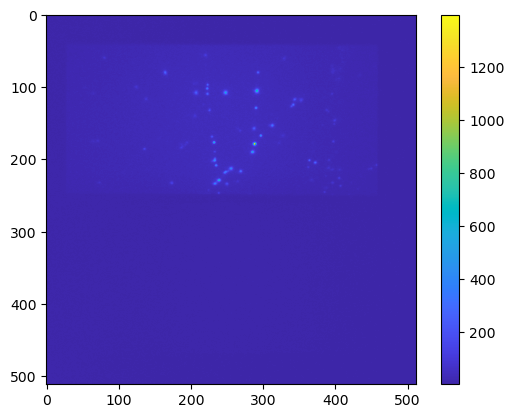

In [6]:
ii = 0
vmin = np.min(stack[0][ii])
vmax = np.max(stack[0][ii])
print(vmin, vmax)
plt.imshow(stack[0][ii], cmap=parula)
plt.colorbar()
plt.show()

Pixel range values: [ 2.7192984 , 1399.6228 ]
S/N ratio (in descending order):
[45.71, 24.93, 24.86, 24.37, 21.92, 20.74, 20.49, 17.16, 15.85, 15.64, 14.57, 13.55, 13.47, 13.23, 12.08, 12.0, 11.52, 10.67, 10.46, 9.63, 8.76, 8.63, 8.15, 8.08, 8.06, 7.9, 7.69, 7.03, 7.02, 6.71, 6.63, 6.54, 6.46, 6.34, 6.05, 5.55, 5.41, 5.3, 5.26, 5.19, 5.19, 5.04, 4.82, 4.75, 4.73, 4.71, 4.66, 4.56, 4.37, 4.32, 4.29, 4.27, 4.21, 4.19, 4.18, 4.12, 4.1, 4.07, 4.01, 3.99, 3.98, 3.94, 3.94, 3.88, 3.87, 3.85, 3.83, 3.82, 3.8, 3.78, 3.78, 3.77, 3.75, 3.75, 3.74, 3.74, 3.71, 3.7, 3.67, 3.66, 3.66, 3.65, 3.65, 3.63, 3.62, 3.62, 3.61, 3.6, 3.59, 3.59, 3.58, 3.58, 3.57, 3.56, 3.55, 3.54, 3.53, 3.52, 3.52, 3.52, 3.51, 3.51, 3.5, 3.5, 3.5, 3.48, 3.46, 3.46, 3.46, 3.45, 3.45, 3.45, 3.44, 3.44, 3.44, 3.43, 3.41, 3.41, 3.41, 3.4, 3.39, 3.39, 3.38, 3.37, 3.37, 3.36, 3.36, 3.36, 3.36, 3.36, 3.36, 3.35, 3.35, 3.34, 3.33, 3.33, 3.33, 3.33, 3.33, 3.32, 3.32, 3.32, 3.32, 3.31, 3.31, 3.31, 3.3, 3.3, 3.29, 3.29, 3.29, 3.29, 3.

<Figure size 1400x400 with 0 Axes>

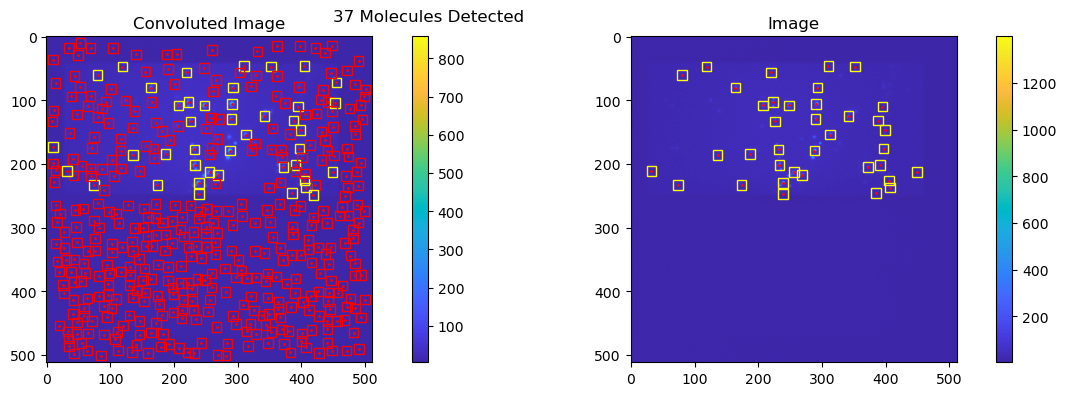

In [7]:
# preloc setup
ll = 0
ii = 0
sigma = 1
min_dist = 7        # default = 7, min dist of two signals
threshold_abs = 5   # default = 5, minimum pix value
threshold_rel = 5  # default = 10, singal to noise ratio
N_crop = 15 # default = 19, defines how many pixels one loc has
figsize = (14, 4)

preloc_setup(stack[ll][ii], sigma=sigma, min_dist=min_dist, threshold_abs=threshold_abs, threshold_rel=threshold_rel, N_crop=N_crop, figsize=figsize)

Stack 1
--- Preloc started ---
# frames: 	 7817
Analizing ... 
 0 - 10  %
10 - 20  %
20 - 30  %
30 - 40  %
40 - 50  %
50 - 60  %
60 - 70  %
70 - 80  %
80 - 90  %
90 - 100 %
--- Preloc completed ---
# molecules:  	 137266


/mnt/d/Simon Jaritz/mlefitgpu-main/SMLM.py:2357: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


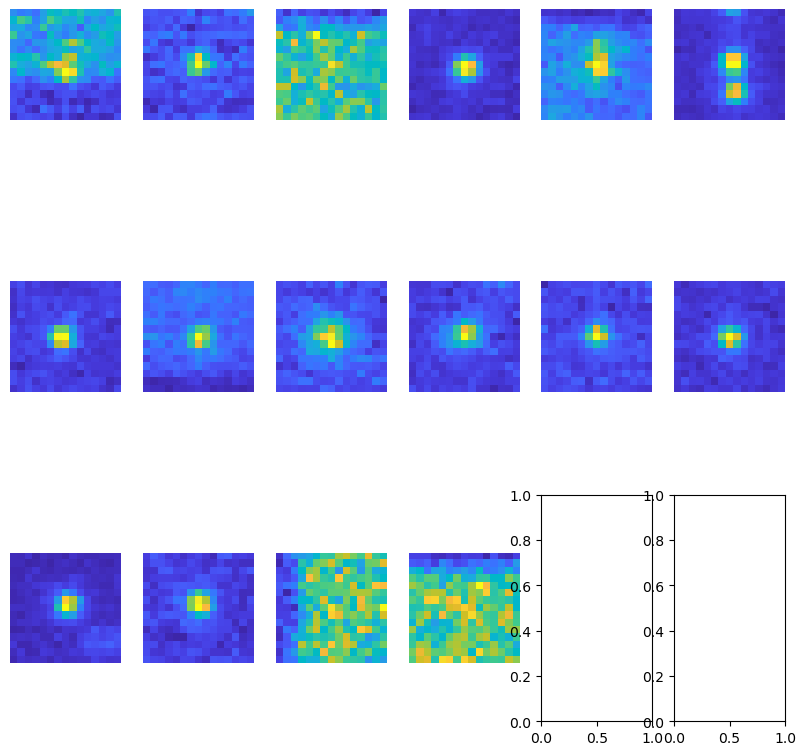

In [8]:
images, prelocs = [], []
for i in range(len(stack)) :
    print('Stack', i+1)
    tmp_prelocs, tmp_I_photons = preloc_and_crop(stack[i], sigma=sigma, min_dist = min_dist, threshold_abs=threshold_abs, threshold_rel=threshold_rel, N_crop =N_crop, show_progress=True)
    images.append(tmp_I_photons)
    prelocs.append(tmp_prelocs)
    show_prelocs(images[i], n=16)

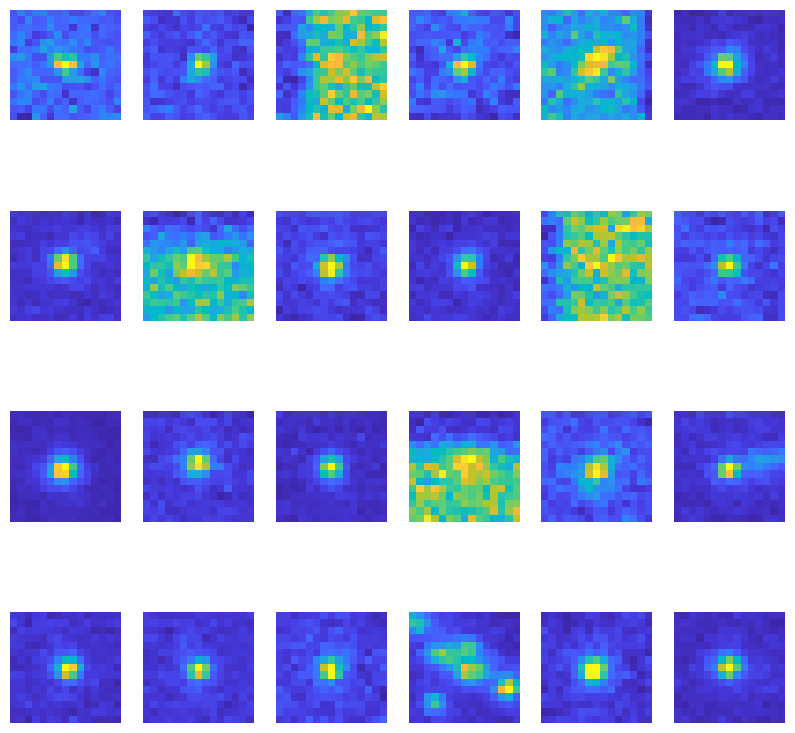

In [9]:
show_prelocs(images[ll], n=24)

30.619299

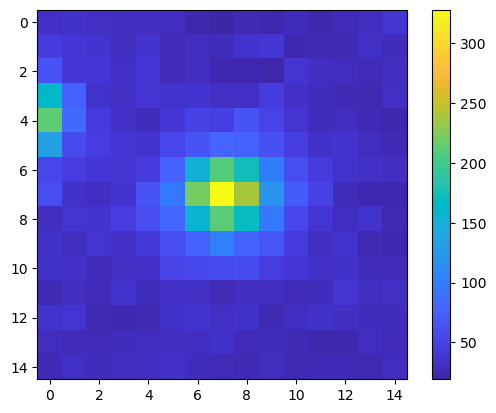

In [10]:
plt.imshow(images[0][100], cmap=parula)
plt.colorbar()
images[0][0].min()

In [11]:
# MATLAB aberr
file = 'aberrations.mat'
noll_index, aberr, T_fit_coefs = load_aberr(file)
noll_index = noll_index.astype(int)
aberr[2] = 0 # delete defocus (Noll 4)

# mask = np.where(np.isin(noll_index, [5, 6, 7, 8, 9, 10, 11, 22, 37, 56]))
mask = np.where(np.isin(noll_index, np.arange(5, 67)))
noll_index = noll_index[mask]
aberr = aberr[mask]

noll_index, aberr

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
        56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 array([-7.86112864e-02,  7.44143286e-02,  6.68127402e-03, -2.86739922e-02,
         3.45017751e-02, -7.32689955e-03,  2.89633066e-01, -1.38265197e-02,
         7.67658452e-03, -1.75936630e-02,  1.91305956e-02,  2.13880650e-02,
        -2.73500503e-02, -6.56382304e-03, -2.19679077e-02, -9.55067848e-03,
        -1.27314656e-03,  3.81277851e-01, -2.47165358e-02, -1.38536437e-02,
        -3.69925583e-03,  7.03582995e-03,  1.24550611e-02,  2.71356660e-04,
        -3.14627024e-02, -3.83955803e-03, -1.56200318e-02,  1.39133434e-02,
         2.62254272e-03,  1.16073865e-02,  1.38782449e-02, -4.16102763e-03,
         1.21134165e-01,  1.99964768e-02, -1.84695202e-02, -1.04883958e-02,
         4.04138579e-03,  8.268979

In [12]:
import importlib
import SMLM ; importlib.reload(SMLM)
from SMLM import *

ll = 0
z_min = -300
z_max = 400
h1 = psf(z_defocus = 600,
        z_min = z_min,
        z_max = z_max,
        wavelength = 670,
        Nx = N_crop+4,   # default = 19+4
        os = 2, # oversampling
        ux = cam.pixsize/obj.M,
        uz = 5,       # default = 100, it should be (z_max-z_min)/uz = int //2 or 5 is good
        RI = [1.33,1.518], # default:  [1.33, 1.518],  sample, immersion medium
        Z_modes = noll_index,
        Z_magn =  aberr,
        Ts_coefs = obj.Ts_coefs,
        Tp_coefs = obj.Tp_coefs,
        sigma = 100, # default: sigma = 100, use the same value as for the abberations (100)... or 80
        interp_method = 'lanczos5',
        correct_RI_mismatch = 'no')



I0000 00:00:1742473867.222660  208156 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [13]:
ll = 0
z_min = -400
z_max = 500
h1 = psf(z_defocus = 600,
        z_min = z_min,
        z_max = z_max,
        wavelength = 670,
        Nx = N_crop+4,   # default = 19+4
        os = 2, # oversampling
        ux = cam.pixsize/obj.M,
        uz = 5,       # default = 100, it should be (z_max-z_min)/uz = int //2 or 5 is good
        RI = [1.33, 1.518], # default:  [1.33, 1.518],  sample, immersion medium
        Z_modes = noll_index,
        Z_magn =  aberr,
        Ts_coefs = obj.Ts_coefs,
        Tp_coefs = obj.Tp_coefs,
        sigma = 100, # default: sigma = 100, use the same value as for the abberations (100)... or 80
        interp_method = 'lanczos5',
        correct_RI_mismatch = 'no')

100


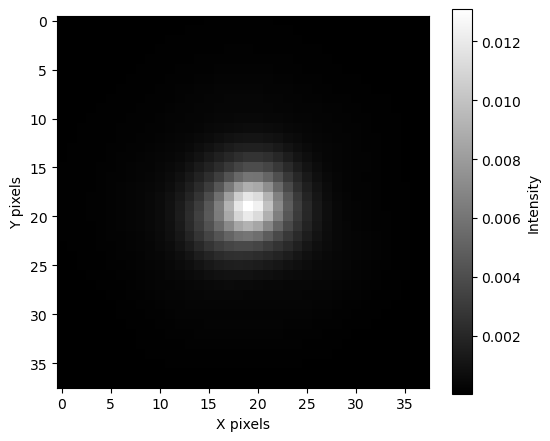

In [14]:
h_interest = 100
z_index = int((h_interest - (h1.z_min * 1e9)) / (h1.uz * 1e9))
print(z_index)

# Extract the PSF slice at the given height
psf_slice = h1.data[...,z_index]

# Plot the PSF slice
plt.figure(figsize=(6, 5))
plt.imshow(psf_slice, cmap='gray')
plt.colorbar(label='Intensity')
plt.xlabel('X pixels')
plt.ylabel('Y pixels')
plt.show()



# Saving PSF

In [15]:
# for d2 in [100,150,200]:
#     for hf in [100,110,150,160,200,210]:
#         for RI in range(133,152):
#             ll = 0
#             z_min = 0
#             z_max = 300
#             h1 = psf(z_defocus = 500,
#                     z_min = z_min,
#                     z_max = z_max,
#                     wavelength = 670,
#                     Nx = N_crop+4,   # default = 19+4
#                     os = 2, # oversampling
#                     ux = cam.pixsize/obj.M,
#                     uz = 5,       # default = 100, it should be (z_max-z_min)/uz = int //2 or 5 is good
#                     RI = [1.33, RI/100,1.518], # default:  [1.33, 1.518],  sample, immersion medium
#                     d2 = d2,
#                     Z_modes = [5, 6, 7, 8, 11], # noll indices
#                     Z_magn =   [0, 0, 0, 0, 0],
#                     Ts_coefs = obj.Ts_coefs,
#                     Tp_coefs = obj.Tp_coefs,
#                     sigma = 100, # default: sigma = 100, use the same value as for the abberations (100)... or 80
#                     interp_method = 'lanczos5',
#                     correct_RI_mismatch = 'no')
                
#             hf = hf
#             z_index = int((hf - (h1.z_min * 1e9)) / (h1.uz * 1e9))
            
#             # Extract the PSF slice at the given height
#             psf_slice = h1.data[...,z_index]
#             df = pd.DataFrame(psf_slice)  # Convert array to DataFrame
#             df.to_csv(f"different_PSF_h1_data_def500_RI{RI}_d2{d2}__hf{hf}.csv", index=False, header=False)
# print('script ready')

In [16]:
# # Plot the PSF slice
# plt.figure(figsize=(6, 5))
# plt.imshow(df, cmap='gray')
# plt.colorbar(label='Intensity')
# plt.xlabel('X pixels')
# plt.ylabel('Y pixels')
# plt.show()

In [17]:

# for RI in range(133,160):
#     ll = 0
#     z_min = -300
#     z_max = 400
#     h1 = psf(z_defocus = 600,
#             z_min = z_min,
#             z_max = z_max,
#             wavelength = 670,
#             Nx = N_crop+4,   # default = 19+4
#             os = 2, # oversampling
#             ux = cam.pixsize/obj.M,
#             uz = 5,       # default = 100, it should be (z_max-z_min)/uz = int //2 or 5 is good
#             RI = [1.33, RI/100,1.518], # default:  [1.33, 1.518],  sample, immersion medium
#             d2 = 100,
#             Z_modes = noll_index,
#             Z_magn =  aberr,
#             Ts_coefs = obj.Ts_coefs,
#             Tp_coefs = obj.Tp_coefs,
#             sigma = 100, # default: sigma = 100, use the same value as for the abberations (100)... or 80
#             interp_method = 'lanczos5',
#             correct_RI_mismatch = 'no'
        
#     h_interest = 110
#     z_index = int((h_interest - (h1.z_min * 1e9)) / (h1.uz * 1e9))
    
#     # Extract the PSF slice at the given height
#     psf_slice = h1.data[...,z_index]

#     df = pd.DataFrame(psf_slice)  # Convert array to DataFrame
#     df.to_csv(f"different_PSF_h1_data_{RI}_d2_100_{h_interest}.csv", index=False, header=False)

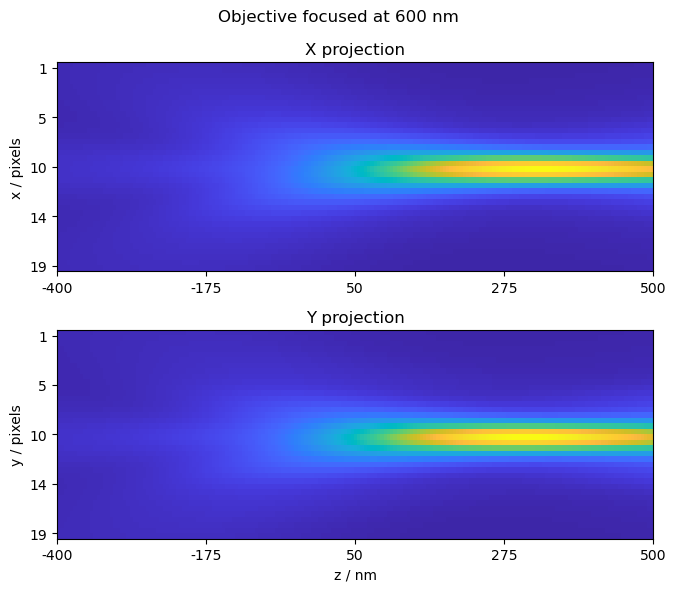

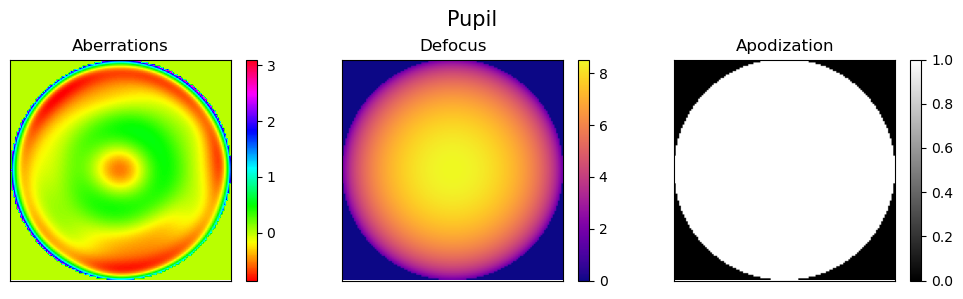

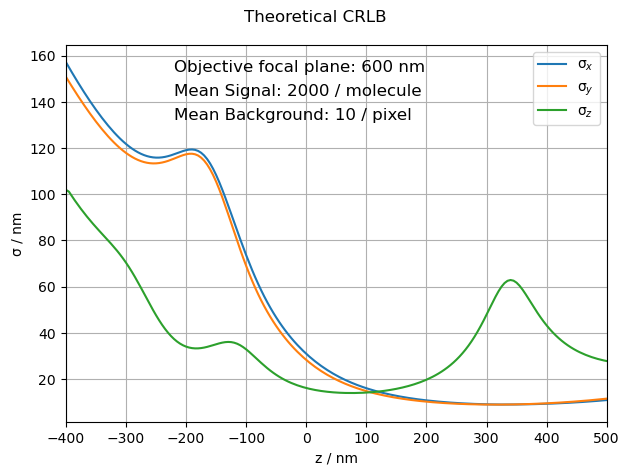

In [18]:
h1.show_projection()
h1.show_pupil()
h1.show_CRLB(cam, s=2000, bg=10)

--- Precise fit ---
# of Batches : 138
Progress:
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
--- Fit completed ---


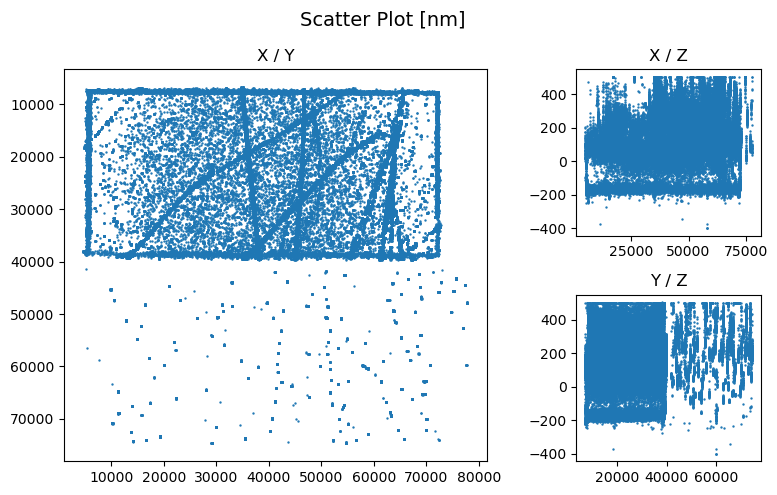

In [19]:
sl = slice(len(images[ll]))
results, raw_results = perform_fit(images[ll][sl], prelocs[ll][sl], h1, show_progress=True)
show_results_2d(results, marker_size = 0.5)

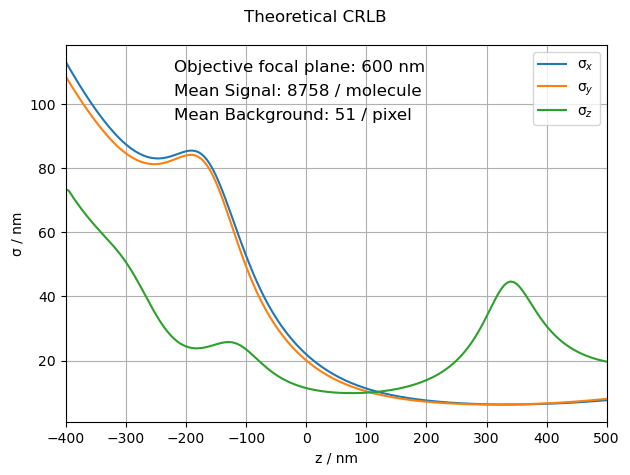

In [20]:
mean_photon = np.mean(results['signal'])
mean_bg = np.mean(results['bg'])

CRLB_plot_save = h1.show_CRLB(cam, s=mean_photon, bg=mean_bg,export=True)

In [21]:
CRLB_plot_save

(Array([113.09007  , 111.46893  , 109.86953  , 108.29647  , 106.75187  ,
        105.23762  , 103.75556  , 102.30738  , 100.89478  ,  99.5194   ,
         98.18305  ,  96.88751  ,  95.634766 ,  94.42676  ,  93.26572  ,
         92.1539   ,  91.09368  ,  90.0875   ,  89.1379   ,  88.24745  ,
         87.41877  ,  86.654396 ,  85.9569   ,  85.32881  ,  84.77253  ,
         84.29036  ,  83.88437  ,  83.55646  ,  83.308    ,  83.13991  ,
         83.0522   ,  83.043816 ,  83.112274 ,  83.253265 ,  83.46013  ,
         83.72333  ,  84.02984  ,  84.36262  ,  84.700066 ,  85.0158   ,
         85.27847  ,  85.45258  ,  85.49943  ,  85.37916  ,  85.05354  ,
         84.48886  ,  83.65949  ,  82.55051  ,  81.15938  ,  79.49647  ,
         77.58389  ,  75.45324  ,  73.14241  ,  70.69228  ,  68.14363  ,
         65.53494  ,  62.900867 ,  60.271545 ,  57.6729   ,  55.1266   ,
         52.650307 ,  50.25812  ,  47.96023  ,  45.76353  ,  43.671555 ,
         41.68509  ,  39.802822 ,  38.0216   ,  36.

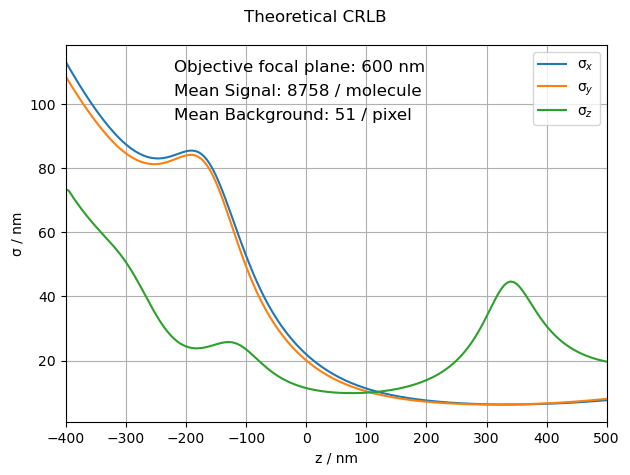

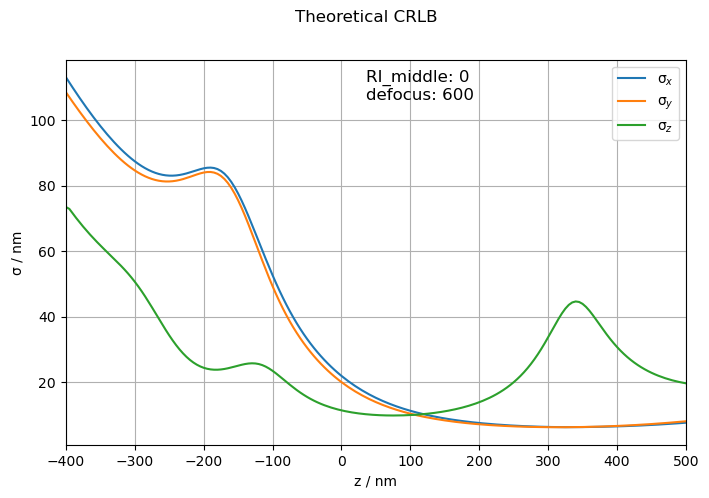

In [22]:

RI_val_i = 0
defocus_val_i = 600

def save_CRLB(h1):
    CRLB_plot_save = h1.show_CRLB(cam, s=np.mean(results['signal']), bg=np.mean(results['bg']),export=True)
    
    x_axis = h1.z_vec * 1e9  # z range
    fig,ax=plt.subplots(figsize=(8,5))
    ax.plot(x_axis,CRLB_plot_save[0],label=r'σ$_{x}$')
    ax.plot(x_axis,CRLB_plot_save[1],label=r'σ$_{y}$')
    ax.plot(x_axis,CRLB_plot_save[2],label=r'σ$_{z}$')
    ax.set_xlabel('z / nm')
    ax.set_ylabel('σ / nm')
    ax.legend()
    ax.grid()
    ax.set_xlim(min(x_axis),max(x_axis))
    
    fig.suptitle(f'Theoretical CRLB')
    fig.text(0.5, 0.8, f'RI_middle: {RI_val_i}\ndefocus: {defocus_val_i}', fontsize=12, color='black', rotation=0)
    fig.savefig(f'CRLB_def_{defocus_val_i}_n133_n{RI_val_i}_n1518.png',dpi=500)

save_CRLB(h1)

In [23]:
type(CRLB_plot_save)

tuple

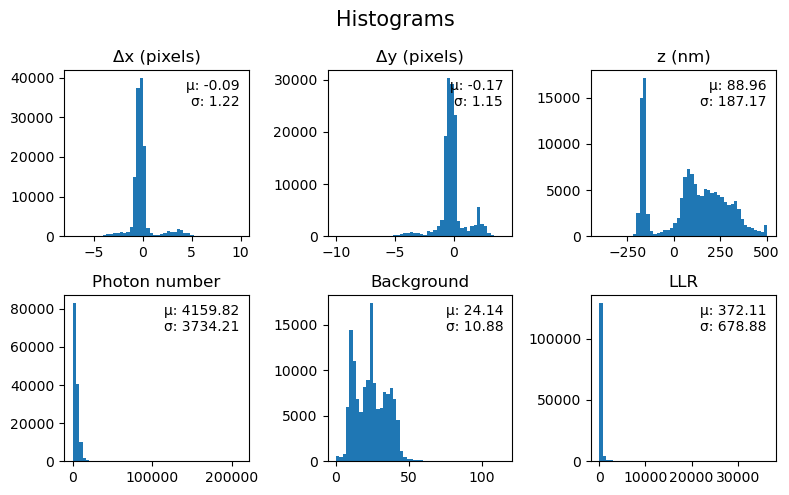

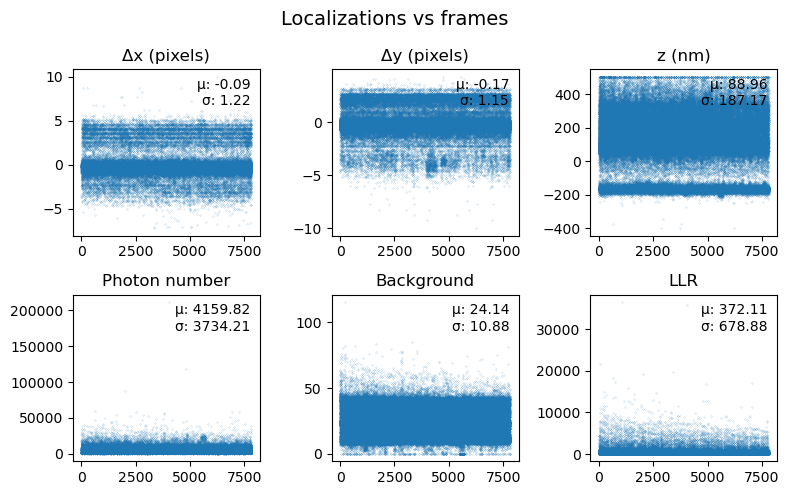

In [24]:
#FILTERING & VISUALIZATION
#show_results_3d(results)
#show_results_2d(results_r, marker_size = 0.2)
show_results_hist(results, raw_results, bins = 50)
# show_results_1d(results, raw_results, marker_size = 0.01)
show_results_time(results, raw_results, marker_size=0.01)

In [25]:
results

,id,frame,x,y,z,signal,bg,LLR
0,1,1,46087.231157,28630.774170,207.661148,17039.441406,44.872555,239.517914
1,2,1,46573.446931,16890.542064,80.644920,18278.566406,37.520111,369.518829
2,3,1,38159.500771,36691.514006,158.289856,9012.621094,64.082092,6229.070801
3,4,1,39636.855659,17275.669159,75.360420,13795.851562,41.291023,240.598541
4,5,1,37096.831522,28294.668977,298.019165,6267.014648,45.283501,751.862976
...,...,...,...,...,...,...,...,...
137261,137262,7817,5543.469620,15169.134645,-174.615143,6799.680176,9.430578,308.029449
137262,137263,7817,5610.000381,13107.009659,-174.518570,6661.333008,9.913850,254.784912
137263,137264,7817,71979.165802,18846.828346,-174.054916,4887.794922,11.238445,244.710556
137264,137265,7817,71982.521935,26957.384472,-181.141708,4649.640137,11.434735,235.289978


mean LLR 372.11148
mean signal 4159.8174
mean bg 24.14093


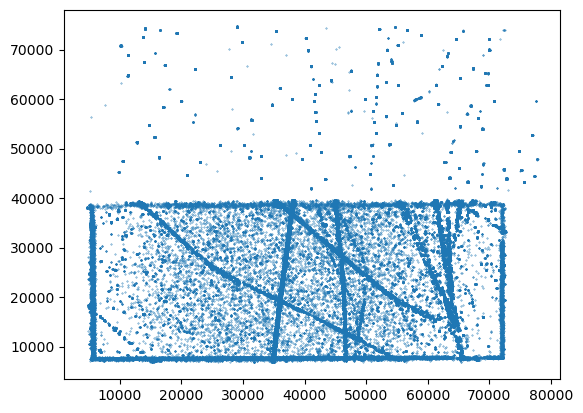

In [26]:

filt_res = results.copy()
# filt_res = filt(filt_res,'LLR',0,1000)
# filt_res = filt(filt_res,'signal',500,0.5e6)

print('mean LLR',np.mean(filt_res['LLR']))
print('mean signal',np.mean(filt_res['signal']))
print('mean bg',np.mean(filt_res['bg']))

fig,ax = plt.subplots()
ax.scatter(filt_res['x'],filt_res['y'],s=0.1)
# ax.axis('equal')

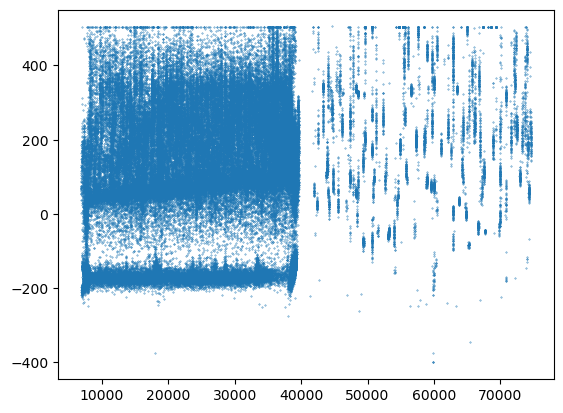

In [27]:
fig,ax = plt.subplots()
ax.scatter(filt_res['y'],filt_res['z'],s=0.1)

(array([3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 6.0000e+00, 9.0000e+00, 8.0000e+00, 1.6000e+01,
        5.3000e+01, 2.0800e+02, 6.6300e+02, 1.8430e+03, 4.6520e+03,
        1.0326e+04, 1.2800e+04, 4.2980e+03, 1.6580e+03, 8.0100e+02,
        3.9000e+02, 2.1200e+02, 1.4100e+02, 1.1500e+02, 1.5200e+02,
        1.8400e+02, 2.1000e+02, 2.8100e+02, 2.8600e+02, 3.5900e+02,
        3.3800e+02, 3.6900e+02, 4.0200e+02, 5.0300e+02, 6.3700e+02,
        7.5600e+02, 8.9900e+02, 1.1310e+03, 1.7280e+03, 2.4430e+03,
        3.0560e+03, 3.3820e+03, 3.6130e+03, 3.6900e+03, 3.4820e+03,
        3.2320e+03, 2.9830e+03, 2.6630e+03, 2.3190e+03, 2.1260e+03,
        2.0940e+03, 2.3060e+03, 2.4380e+03, 2.6690e+03, 2.5030e+03,
        2.5280e+03, 2.3400e+03, 2.3220e+03, 2.4190e+03, 2.3520e+03,
        2.2290e+03, 2.2070e+03, 2.1750e+03, 2.03

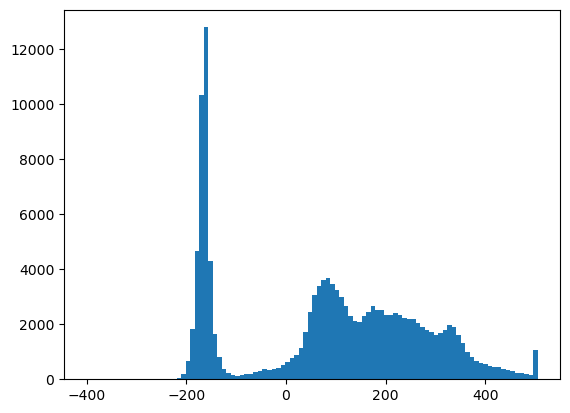

In [28]:
fig,ax = plt.subplots()
# ax.scatter(filt_res['y'],filt_res['z'],s=0.01)
ax.hist(filt_res['z'],100)

In [29]:
# Using different RI and defocus 
defocus_val = [560,600,640]

# 2_1_2
# defocus_val = [600, 612, 634, 650, 579, 512, 658, 586]

# 2_1_3
# defocus_val = [601,572]

# 2_2_1
# defocus_val = [473, 499, 485, 523]

# 2_4_3




# RI_val = [1.33,1.38,1.40,1.42,1.44,1.46,1.48,1.518]

In [ ]:
import gc
from jax.config import config
import jax
config.update('jax_enable_x64', False)
gc.collect()

counter = 0 # To track the progress of the script

for defocus_val_i in defocus_val:
    ll = 0
    z_min = -300
    z_max = 400
    # z_min and z_max define the range of the datapoints
    
    h1 = psf(z_defocus = defocus_val_i,
            z_min = z_min,
            z_max = z_max,
            wavelength = 670,
            Nx = N_crop+4,   # default = 19+4
            os = 2, # oversampling
            ux = cam.pixsize/obj.M,
            uz = 5, # default = 100, it should be (z_max-z_min)/uz = int //2 or 5 is good
            RI = [1.33, 1.518], # default:  [1.33, 1.33],  sample, immersion medium
            Z_modes = noll_index,
            Z_magn =  aberr,
            Ts_coefs = obj.Ts_coefs,
            Tp_coefs = obj.Tp_coefs,
            sigma = 100, # default: sigma = 100, use the same value as for the abberations (100)
            interp_method = 'lanczos5',
            correct_RI_mismatch = 'no')
    sl = slice(len(images[ll]))
    results, raw_results = perform_fit(images[ll][sl], prelocs[ll][sl], h1, show_progress=False)

    # Apply the drift correction
    drift = pd.read_csv('drift_sample_16_1_1_p1.csv')
    results['dig']=np.digitize(results['frame'], bins=np.arange(0, 30000, 500))
    av_drift=drift.groupby(drift['dig']).mean()
    results['x_cor']=results['x'].copy()
    results['y_cor']=results['y'].copy()
    ux = cam.pixsize/obj.M
    uz = 5
    
    for i in set(results['dig']):
        avdx=av_drift[av_drift.index==i]['dx'].values 
        avdy=av_drift[av_drift.index==i]['dy'].values
        a=results[results['dig']==i]['x_cor']-avdx[0]*ux
        b=results[results['dig']==i]['y_cor']-avdy[0]*ux
        results.loc[results['dig']==i, 'x_cor']=a.values
        results.loc[results['dig']==i, 'y_cor']=b.values
    
    # Save the results
    results.to_csv(f'results_def_{defocus_val_i}_nomid_n133_n1518.csv')
    raw_results.to_csv(f'raw_results_def_{defocus_val_i}_nomid_n133_n1518.csv')
    gc.collect()
    jax.device_put(None)  # Free memory manually
    print('script is ready')

In [ ]:
## Inserting a middle layer

In [30]:
# Using different RI and defocus 
# Define which RI and which defocus values you would like to analyze


# ROI 2_1_2
# defocus_val = [600, 612, 634, 650, 579, 512, 658, 586]
# middle_layers= [243, 236, 250, 157, 138, 145, 220, 219]

# ROI 2_1_3
# defocus_val = [601,572]
# middle_layers= [214,217]

# ROI 2_2_1
# defocus_val = [473, 499, 485, 523]
# middle_layers = [170, 162, 221, 197]

# ROI 2_4_3
# defocus_val = [431]
# middle_layers = [188] # not correct !

# ROI 2_5_1
defocus_val = [488,500]
middle_layers = [223,296] 

# ROI 7_1_1
# defocus_val = [406]
# middle_layers = [184] 

# ROI 7_2_1
# defocus_val = [621]
# middle_layers = [238]

# ROI 16_1_1
# defocus_val = [586]
# middle_layers = [267]

RI_val = [1.33,1.38,1.40,1.42,1.44,1.46,1.48,1.518]


In [31]:
import gc
from jax.config import config
import jax
config.update('jax_enable_x64', False)
gc.collect()

counter = 0 # To track the progress of the script
for k in range(len(defocus_val)):
    mid_layer = middle_layers[k]
    defocus_val_i = defocus_val[k]
    
    for RI_val_i in RI_val:
        counter += int((1/len(RI_val))*100)
        print(counter) # To see the progress of the program 
       
        ll = 0
        z_min = -300
        z_max = 400
        # z_min and z_max define the range of the datapoints
        
        h1 = psf(z_defocus = defocus_val_i,
                z_min = z_min,
                z_max = z_max,
                wavelength = 670,
                Nx = N_crop+4,   # default = 19+4
                os = 2, # oversampling
                ux = cam.pixsize/obj.M,
                uz = 5,       # default = 100, it should be (z_max-z_min)/uz = int //2 or 5 is good
                RI = [1.33,RI_val_i, 1.518], # default:  [1.33, 1.33],  sample, immersion medium
                d2 = mid_layer, # Thickness of the middle layer
                Z_modes = noll_index,
                Z_magn =  aberr,
                Ts_coefs = obj.Ts_coefs,
                Tp_coefs = obj.Tp_coefs,
                sigma = 100, # default: sigma = 100, use the same value as for the abberations (100)
                interp_method = 'lanczos5',
                correct_RI_mismatch = 'no')

        sl = slice(len(images[ll]))
        results, raw_results = perform_fit(images[ll][sl], prelocs[ll][sl], h1, show_progress=False)

        
        # Apply the drift correction
        drift = pd.read_csv('drift_sample_2_5_1_p1.csv')
        
        results['dig']=np.digitize(results['frame'], bins=np.arange(0, 30000, 500))
        av_drift=drift.groupby(drift['dig']).mean()
        
        results['x_cor']=results['x'].copy()
        results['y_cor']=results['y'].copy()
        
        ux = cam.pixsize/obj.M
        uz = 5
        
        for i in set(results['dig']):
            avdx=av_drift[av_drift.index==i]['dx'].values 
            avdy=av_drift[av_drift.index==i]['dy'].values
            a=results[results['dig']==i]['x_cor']-avdx[0]*ux
            b=results[results['dig']==i]['y_cor']-avdy[0]*ux
            results.loc[results['dig']==i, 'x_cor']=a.values
            results.loc[results['dig']==i, 'y_cor']=b.values

        # Save the results
        results.to_csv(f'results_def_{defocus_val_i}_mid_{mid_layer}_n133_n{RI_val_i}_n1518.csv')
        raw_results.to_csv(f'raw_results_def_{defocus_val_i}_mid_{mid_layer}_n133_n{RI_val_i}_n1518.csv')
        
        gc.collect()
        jax.device_put(None)  # Free memory manually

print('script is ready')

12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
script is ready


In [ ]:
#filter func
def filt(df, var, low, high):
    return df[(df[var]>low) & (df[var]<high)]

results_p = results.copy()
results_p = filt(results_p,'x_cor',25000,50000)
results_p = filt(results_p,'y_cor',8000,40000)

# results_p = filt(results_p,'x_cor',37500,40000)
# results_p = filt(results_p,'y_cor',20000,28000)

fig,ax = plt.subplots()
ax.scatter(results_p['x_cor'],results_p['y_cor'],s=0.1)

In [ ]:
fig,ax = plt.subplots()
ax.scatter(results_p['y_cor'],results_p['z'],s=0.1)

In [ ]:
# FILTERING

import importlib
import SMLM ; importlib.reload(SMLM)
from SMLM import *

pxl = 1.5
filtered_results, filtered_raw_results, filter_idx = filter_results(results, raw_results,
            # x_range = (1950, 20500), y_range = (1500, 35000),
            x_pxl_range = (-pxl, pxl), y_pxl_range = (-pxl, pxl),
            z_range = (-500, 500),
            # signal_range = (140, 5000),
            # bg_range = (20, 40),
            # LLR_range = (0, 3000),
            print_fraction=True)

# show_results_3d(filtered_results)
show_results_2d(filtered_results, marker_size = 0.1)
show_results_hist(filtered_results, filtered_raw_results, bins = 100)
show_results_time(filtered_results, filtered_raw_results, exp_time = 20, marker_size = 0.1)

In [ ]:
show_pixelation(h1, results, bins_plotted = 1, bins=20)

In [ ]:
show_molecules(images[0], filter_idx)

In [ ]:
# df = ts_results
df = filtered_results
fig = px.scatter(x = df['x'], y = df['y'], color = df['z'], opacity = 1)
fig.update_traces(marker_size=5)
# fig.update_layout(width=800, height=800, yaxis = dict(zeroline=True, autorange='reversed'))
fig.update_layout(width=800, 
                  height=800,
                  xaxis=dict(zeroline=False, showgrid=False, showticklabels=False),
                  yaxis=dict(zeroline=False, autorange='reversed', showgrid=False, showticklabels=False), 
                )
fig.show()

In [ ]:
# clusterization

data = ts_results.to_numpy()

method = 'DBSCAN'
method = 'DBSCAN3D'
# method = 'OPTICS'
# method = 'HDBSCAN'

# dbscan: larger eps implies smaller densities
eps = 80
min_samples = 40

#optics
max_eps = 200
xi = 0.05
min_cluster_size = 100

n_bins = 250
figsize = (18,18)
label = False
dict_nanorulers, data_npcs = find_npcs(data, method, eps, max_eps, xi, min_cluster_size, min_samples, label, n_bins, figsize)

In [ ]:
import importlib
import SMLM ; importlib.reload(SMLM)
from SMLM import *

if __name__ == '__main__':
    app = dash_plot(data_npcs)
    # app = dash_plot(filtered_results)
    app.run_server(debug=True, port=8052)